In [1]:
from private.db.tianrun.spot.fdw.new_energy_actual_power import market_actual_power, market_name_dict
from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData

from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla import VanillaTransformer, vanilla_transformer_tester, vanilla_transformer_trainer
import numpy
import pickle
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt
from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler

In [2]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"
with open(f"{root}\\2024-11-29.pfd", "rb") as f:
    pfd = pickle.loads(f.read())

In [49]:
forecast_date = [TimeStamp(2024,10,1),TimeStamp(2024,10,2)]
data = pfd["cma","evening",1,1, forecast_date]
actual = market_actual_power(
    market_name_dict["shanxi"], (forecast_date[0] + ["day",1]).get_date_string()
).aggregate(["hour", 1], numpy.sum, align=True, align_domain=[(forecast_date[0] + ["day",1]).get_date_string(), (forecast_date[0] + ["day",2]).get_date_string()])["power"]
x = torch.Tensor(numpy.apply_along_axis(MinMax.g, axis=0, arr=data)[:24])
y = torch.Tensor(numpy.apply_along_axis(MinMax.g, axis=0, arr=actual))

In [55]:
input_size = data.shape[1]
d_model = 512
dim_feedforward = d_model * 4
nhead = 8
output_size = 1
num_layers = 2
batch_size = 2
lr = 1e-3
model = VanillaTransformer(
    input_size=input_size,
    output_size=output_size,
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)

In [56]:
trained_model = vanilla_transformer_trainer(model, x, y, batch_size, 100, lr=lr)

100%|██████████| 100/100 [00:11<00:00,  8.97it/s]


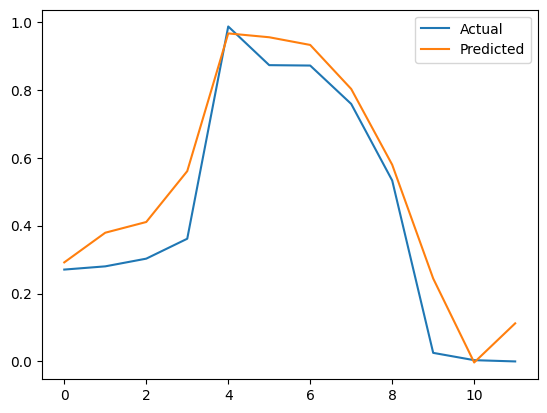

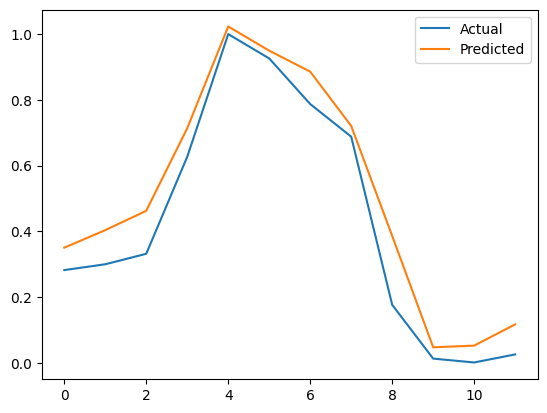

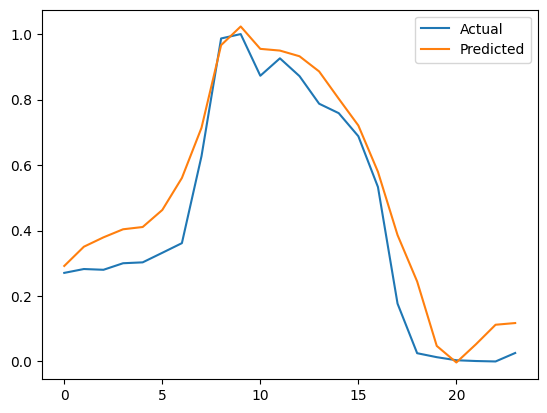

In [57]:
p_train = vanilla_transformer_tester(trained_model, x, batch_size)
for _ in range(batch_size):
    plt.plot(y.reshape(-1,batch_size,1)[:,_], label='Actual')
    plt.plot(p_train[:,_], label='Predicted')
    plt.legend()
    plt.show()
    
plt.plot(y.reshape(-1), label='Actual')
plt.plot(p_train.reshape(-1), label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

In [59]:
forecast_date_hat = TimeStamp(2024,10,2)
# data_hat = pfd["cma","morning",1,1, forecast_date_hat]
actual_hat = market_actual_power(
    market_name_dict["shanxi"], (forecast_date_hat + ["day",1]).get_date_string()
).aggregate(["hour", 1], numpy.sum, align=True, align_domain=[(forecast_date_hat + ["day",1]).get_date_string(), (forecast_date_hat + ["day",2]).get_date_string()])["power"]
x_hat = torch.Tensor(numpy.apply_along_axis(MinMax.g, axis=0, arr=data))
y_hat = torch.Tensor(numpy.concatenate((y, numpy.apply_along_axis(MinMax.g, axis=0, arr=actual_hat))))

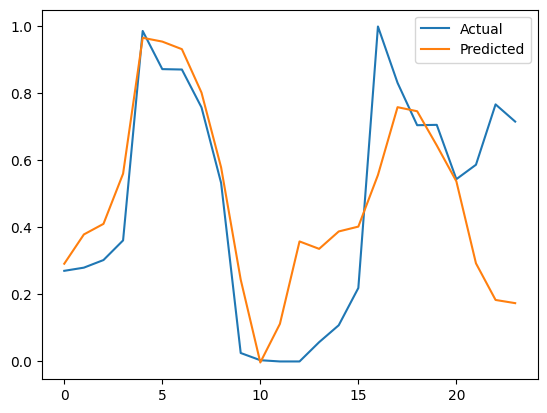

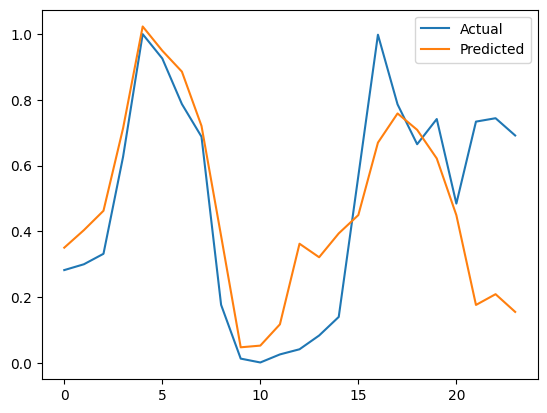

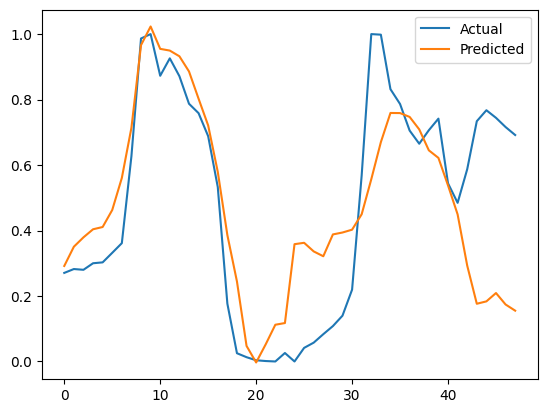

In [60]:
p_train = vanilla_transformer_tester(trained_model, x_hat, batch_size)
for _ in range(batch_size):
    plt.plot(y_hat.reshape(-1,batch_size,1)[:,_], label='Actual')
    plt.plot(p_train[:,_], label='Predicted')
    plt.legend()
    plt.show()
    
plt.plot(y_hat.reshape(-1), label='Actual')
plt.plot(p_train.reshape(-1), label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()